In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pickle
import random
import scipy
from collections import OrderedDict
from sklearn.metrics import f1_score, roc_auc_score

In [2]:
DATASETS_PATH = './data/'
MODELS_PATH = './models/'
TRAIN_SIZE = 0.9

In [3]:
def init_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
init_random_seed()

# Exploratory analysis
By the first glance, fake news mostly associated with politics, political sedition, contains a lot of entities related to organizations or well-known (often political) persons. (Neural Meduza, is that you?)

In [4]:
with open(DATASETS_PATH + 'train.csv', 'r', encoding='utf-8') as fstream:
    freader = csv.reader(fstream, delimiter='\t')
    next(freader)
    general_docs = []
    general_labels = []
    for obs in freader:
        general_docs.append(obs[0])
        general_labels.append(int(obs[1]))

In [5]:
with open(DATASETS_PATH + 'test.csv', 'r', encoding='utf-8') as fstream:
    freader = csv.reader(fstream, delimiter='\t')
    next(freader)
    test_docs = []
    test_labels = []
    for obs in freader:
        test_docs.append(obs[0])
        test_labels.append(int(obs[1]))

In [6]:
general_docs[:3], general_labels[:3]

(['Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы',
  'Агент Кокорина назвал езду по встречке житейской историей',
  'Госдума рассмотрит возможность введения секретных статей Уголовного кодекса'],
 [1, 0, 1])

In [7]:
len(general_docs), len(test_docs)

(5758, 1000)

In [8]:
general_labels = np.array(general_labels)
label_counts = np.unique(general_labels, return_counts=True)

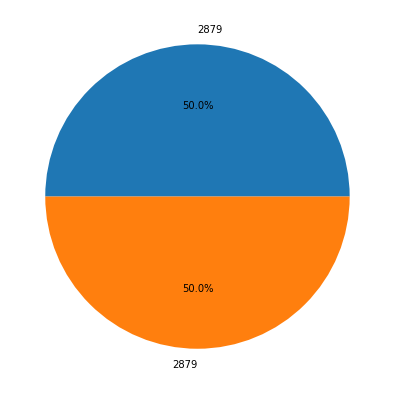

In [9]:
plt.figure(figsize=(7, 7))
plt.pie(label_counts[1], labels=label_counts[1], autopct='%1.1f%%');

## Quick thoughts:
* Small dataset;
* Balanced labels, so **accuracy** metric remains representative enough;
* Short sequences. 

## Train/Eval split

In [10]:
init_random_seed(0)
random.shuffle(general_docs)
init_random_seed(0)
random.shuffle(general_labels)
TRAIN_ABS_SIZE = int(len(general_docs) * TRAIN_SIZE)

train_texts = general_docs[:TRAIN_ABS_SIZE]
eval_texts = general_docs[TRAIN_ABS_SIZE:]
train_labels = general_labels[:TRAIN_ABS_SIZE]
eval_labels = general_labels[TRAIN_ABS_SIZE:]

# Classification with BOW 
1. Lemmatization to reduce vocabulary - baseline-model is simple enough, so lemmatizing won't cause any large information losses.
2. Filtering + Vectorization
3. Classification

In [11]:
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import pymorphy2
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Uer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Text normalization - lemmatizing vs stemming.

1. Russian is the language with high word-inflection, so stemming might be too harsh procedure, even tho quick enough.
2. Dataset is quite small and sequences are short, so lemmatizing won't take long to produce, and will greatly optimize vocabulary size.

It is proposed to use the same lemmatizer as been used in spacy lib.

## Text preprocess

In [12]:
pymorphy = pymorphy2.MorphAnalyzer()

In [13]:
def word_normalizer(word):
    return pymorphy.parse(word)[0].normal_form

In [14]:
class Tokenizer(object):
    def __init__(self, stopwords=None) -> None:
        self.word_normalizer = word_normalizer
        self.stopwords = set(stopwords)
    
    def remove_stopwords(self, document, min_len=4):

        if self.stopwords is None:
            return document        
        document = [token
                for token in document
                if token not in self.stopwords and len(token) >= min_len]
        return document    

    def __call__(self, document):

        tokenized_document = word_tokenize(document)
        tokenized_document = self.remove_stopwords(tokenized_document)
        
        return [self.word_normalizer(token) for token in tokenized_document]

In [15]:
tokenizer = Tokenizer(stopwords.words('russian'))

In [16]:
print(train_texts[0])
print(tokenizer(train_texts[0]))

Кудрин призвал перевести Россию на ветроэнергетику прямо сейчас
['кудрин', 'призвать', 'перевести', 'россия', 'ветроэнергетика', 'прямо']


In [17]:
train_tokenized = [tokenizer(doc) for doc in train_texts]
eval_tokenized = [tokenizer(doc) for doc in eval_texts]

In [18]:
len(train_tokenized), len(eval_tokenized)

(5182, 576)

In [19]:
pseudo_tokenizer = lambda x: x
vectorizer = TfidfVectorizer(
    tokenizer=pseudo_tokenizer,
    lowercase=False,
    max_df=0.7
    )
    
X_train = vectorizer.fit_transform(train_tokenized)
X_eval = vectorizer.transform(eval_tokenized)
X_train.shape, X_eval.shape

((5182, 10068), (576, 10068))

## SVM Model

Motivation behind SVM:
1. Binary classification
2. TF-IDF contains large amount of sparse features

In [20]:
def train_eval_sklearn_clf(clf, X_train, y_train, X_eval, y_eval):
    clf.fit(X_train, y_train)

    train_preds = clf.predict(X_train)
    eval_preds = clf.predict(X_eval)

    train_accuracy = (train_preds == np.array(y_train)).mean()
    eval_accuracy = (eval_preds == np.array(y_eval)).mean()
    print('Train accuracy:', train_accuracy)
    print('Eval accuracy:', eval_accuracy)
    print('Train f1_score:', f1_score(y_eval, eval_preds))
    print('Eval f1_score:', f1_score(y_eval, eval_preds))
    print('Train auc:', roc_auc_score(y_eval, eval_preds))
    print('Eval auc:', roc_auc_score(y_eval, eval_preds))

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
svm_clf = svm.SVC()

In [24]:
cross_val_score(svm_clf, X_train, train_labels, scoring='f1')

array([0.81318681, 0.84332689, 0.82457879, 0.84179104, 0.82514735])

In [25]:
svm_clf = svm.SVC()
train_eval_sklearn_clf(svm_clf, X_train, train_labels, X_eval, eval_labels)

Train accuracy: 0.9984561945194905
Eval accuracy: 0.8315972222222222
Train f1_score: 0.8318890814558058
Eval f1_score: 0.8318890814558058
Train auc: 0.8316252712804436
Eval auc: 0.8316252712804436


# w2v + BiGRU

<p>Possibility to use embeddings that are pre-trained on a much larger dataset, gives the W2V method an advantage due to transfer learning, in compare to BOW.</p>

Optimal utilization of W2V embeddings may be brought by a **light** and **bidirectional** RNN due to:
1. Sequences are short enough, so there is no need in Long Short-Term memory
2. Russian language is quite free regarding the word order.

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from gensim.corpora import Dictionary
from nltk.tokenize import RegexpTokenizer


import zipfile
import gensim
import wget

In [36]:
PRETRAINED_WEIGTHS_NAME = 'gru_fakenews_clf.pt'
MAX_EPOCH = 10
BATCH_SIZE = 128
PAD_TOKEN = '<PAD>'
BOS_TOKEN = '<BOS>'
EOS_TOKEN = '<EOS>'
UNK_TOKEN = '<UNK>'
SPECIAL_TOKENS = [PAD_TOKEN, BOS_TOKEN, EOS_TOKEN, UNK_TOKEN]
special_tokens_map = dict(zip(SPECIAL_TOKENS, [i for i in range(len(SPECIAL_TOKENS))]))

In [13]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed()

## Data preprocess

In [14]:

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
train_tokenized = [word_tokenizer.tokenize(doc.lower()) for doc in train_texts]
eval_tokenized = [word_tokenizer.tokenize(doc.lower()) for doc in eval_texts]

In [15]:
vocabulary = Dictionary(train_tokenized)
vocabulary.filter_extremes(no_above=0.7, no_below=2)
vocabulary.patch_with_special_tokens(special_tokens_map)
VOCABULARY_SIZE = len(vocabulary)
EMBEDDING_DIM = 300

In [16]:
numpy_embeddings = np.zeros(shape=[VOCABULARY_SIZE, EMBEDDING_DIM],dtype=np.float32)

In [17]:
# If there is no pre-trained weights for model, load fastText embeddings
if PRETRAINED_WEIGTHS_NAME is None:
    model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
    # wget.download(model_url)
    w2v_model = gensim.models.KeyedVectors.load(MODELS_PATH + '/187/model.model')
    for word in vocabulary.token2id.keys():
        if word in w2v_model:
            word_emb = w2v_model[word]
            word_idx = vocabulary.token2id[word]
            numpy_embeddings[word_idx] = word_emb

In [18]:
numpy_embeddings.shape

(5787, 300)

In [19]:
train_encoded = [vocabulary.doc2idx(doc, unknown_word_index=special_tokens_map[UNK_TOKEN]) for doc in train_tokenized]
eval_encoded = [vocabulary.doc2idx(doc, unknown_word_index=special_tokens_map[UNK_TOKEN]) for doc in eval_tokenized]

## Dataset building

In [20]:
class SequenceDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        features = torch.LongTensor([special_tokens_map[BOS_TOKEN]] + self.features[idx] + [special_tokens_map[EOS_TOKEN]])
        targets = torch.FloatTensor([self.targets[idx]])
        return (features, targets)

In [21]:
def custom_collate(data):
    features, labels = zip(*data)
    seq_lens = [len(seq) for seq in features]
    features = torch.nn.utils.rnn.pad_sequence(features, batch_first=True, padding_value=special_tokens_map[PAD_TOKEN])
    labels = torch.cat(labels)
    return {'input_ids': features, 'lengths': seq_lens, 'labels': labels} 

In [22]:
train_dataset = SequenceDataset(train_encoded, train_labels)
eval_dataset = SequenceDataset(eval_encoded, eval_labels)

In [23]:
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
eval_dataloader = DataLoader(eval_dataset, BATCH_SIZE, shuffle=True, collate_fn=custom_collate)

In [24]:
next(iter(train_dataloader))

{'input_ids': tensor([[   1, 5784,    3,  ...,    0,    0,    0],
         [   1, 3739,    3,  ...,    0,    0,    0],
         [   1,   47,    3,  ...,    0,    0,    0],
         ...,
         [   1, 1535,    3,  ...,    0,    0,    0],
         [   1, 2686, 2689,  ...,    0,    0,    0],
         [   1,  168,    3,  ...,    0,    0,    0]]),
 'lengths': [12,
  9,
  8,
  12,
  7,
  13,
  8,
  11,
  12,
  19,
  8,
  8,
  8,
  6,
  13,
  8,
  10,
  10,
  11,
  10,
  10,
  8,
  10,
  17,
  22,
  16,
  10,
  11,
  12,
  6,
  8,
  9,
  7,
  10,
  10,
  8,
  12,
  19,
  9,
  8,
  8,
  10,
  11,
  10,
  12,
  13,
  12,
  11,
  11,
  9,
  10,
  8,
  8,
  13,
  9,
  9,
  9,
  13,
  15,
  15,
  14,
  8,
  14,
  11,
  7,
  13,
  12,
  23,
  14,
  7,
  11,
  12,
  11,
  9,
  7,
  11,
  10,
  11,
  15,
  13,
  12,
  9,
  10,
  8,
  7,
  9,
  12,
  16,
  10,
  11,
  10,
  11,
  16,
  8,
  9,
  14,
  9,
  31,
  10,
  13,
  10,
  6,
  10,
  8,
  17,
  15,
  13,
  11,
  11,
  14,
  8,
  9,
  8,
  19,

In [25]:
class Contextualizer(torch.nn.Module):
    def __init__(self, vocabulary_size, targets_size, embedding_size, hidden_state_size, embeddings, dropout=0.1, device='cuda') -> None:
        super().__init__()
        self.device = device
        self.embeddings = torch.nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), freeze=True)
        self.embedding_dropout = torch.nn.Dropout(dropout)
        self.backbone = torch.nn.GRU(embedding_size, hidden_state_size, batch_first=True, bidirectional=True)
        self.out_linear = torch.nn.Linear(2*hidden_state_size, 1)
        

    def forward(self, padded_inp, lengths):
        batch_size, seq_len = padded_inp.shape
        
        inp_embs = self.embeddings(padded_inp)
        inp_embs = self.embedding_dropout(inp_embs)

        packed_padded_inp = torch.nn.utils.rnn.pack_padded_sequence(inp_embs, lengths, batch_first=True, enforce_sorted=False)
        packed_h_matrices, last_h_state = self.backbone(packed_padded_inp)

        h_matrices, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_h_matrices, batch_first=True)

        last_h_state = torch.cat([last_h_state[0], last_h_state[1]], -1)        
        h_proj = self.out_linear(last_h_state)
        return h_proj

## Model initialization

In [26]:
init_random_seed()
model = Contextualizer(VOCABULARY_SIZE, 1, embedding_size=EMBEDDING_DIM, hidden_state_size=2*EMBEDDING_DIM, embeddings=numpy_embeddings, dropout=0.2).to('cuda')

In [27]:
if PRETRAINED_WEIGTHS_NAME is not None:
    model.load_state_dict(torch.load(MODELS_PATH + PRETRAINED_WEIGTHS_NAME))

In [28]:
from functools import reduce
sum(reduce(lambda x, y: x*y,  par.shape) for par in model.parameters())

4984501

In [29]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

## GRU Train/Eval stage

In [30]:
assert PRETRAINED_WEIGTHS_NAME is None, 'Model training is not intended, skip this cell'
train_loss_log = []
eval_loss_log = []
for epoch_id in range(MAX_EPOCH):
    epoch_loss = 0
    train_predicted_labels = []
    train_target_labels = []
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        inp_ids = batch['input_ids'].to(model.device)
        lens = batch['lengths']
        labels = batch['labels'].to(model.device)
        out_logits = model(inp_ids, lens)
        loss = loss_fn(out_logits.flatten(), labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        
        train_predicted_labels += (torch.sigmoid(out_logits.flatten()) > 0.5).float().tolist()
        train_target_labels += labels.tolist()
    train_loss_log.append(epoch_loss/(batch_idx + 1))
    
    epoch_loss = 0
    model.eval()
    eval_predicted_labels = []
    eval_target_labels = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(eval_dataloader):
            inp_ids = batch['input_ids'].to(model.device)
            lens = batch['lengths']
            labels = batch['labels'].to(model.device)
            out_logits = model(inp_ids, lens)
            loss = loss_fn(out_logits.flatten(), labels)
            epoch_loss += loss.item()

            eval_predicted_labels += (torch.sigmoid(out_logits.flatten()) > 0.5).float().tolist()
            eval_target_labels += labels.tolist()
        eval_loss_log.append(epoch_loss/(batch_idx + 1))
        lr_scheduler.step(eval_loss_log[-1])

    print("Epoch Number: {} \t| epoch train loss: {:6.4} \t| epoch eval loss: {:6.4} \t| train_accuracy: {:3.2} \t| eval_accuracy: {:3.2}"\
            .format(
                epoch_id + 1, 
                train_loss_log[-1], 
                eval_loss_log[-1], 
                (np.array(train_predicted_labels) == np.array(train_target_labels)).mean(),
                (np.array(eval_predicted_labels) == np.array(eval_target_labels)).mean()
            )
        )
            

Epoch Number: 1 	| epoch train loss: 0.4947 	| epoch eval loss:  0.339 	| train_accuracy: 0.76 	| eval_accuracy: 0.82
Epoch Number: 2 	| epoch train loss: 0.3369 	| epoch eval loss: 0.3182 	| train_accuracy: 0.85 	| eval_accuracy: 0.85
Epoch Number: 3 	| epoch train loss:  0.281 	| epoch eval loss: 0.2925 	| train_accuracy: 0.88 	| eval_accuracy: 0.87
Epoch Number: 4 	| epoch train loss: 0.2482 	| epoch eval loss:  0.311 	| train_accuracy: 0.9 	| eval_accuracy: 0.85
Epoch Number: 5 	| epoch train loss: 0.2001 	| epoch eval loss: 0.3474 	| train_accuracy: 0.92 	| eval_accuracy: 0.85
Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.
Epoch Number: 6 	| epoch train loss: 0.1657 	| epoch eval loss: 0.4213 	| train_accuracy: 0.94 	| eval_accuracy: 0.85
Epoch Number: 7 	| epoch train loss: 0.1181 	| epoch eval loss: 0.3263 	| train_accuracy: 0.96 	| eval_accuracy: 0.87
Epoch Number: 8 	| epoch train loss: 0.09428 	| epoch eval loss:  0.359 	| train_accuracy: 0.97 	| eval_accuracy:

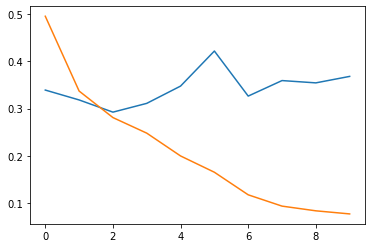

In [31]:
plt.plot(eval_loss_log)
plt.plot(train_loss_log)

In [52]:
predicted_labels = []
target_labels = []
model.eval()
with torch.no_grad():
        for batch_idx, batch in enumerate(eval_dataloader):
            inp_ids = batch['input_ids'].to(model.device)
            lens = batch['lengths']
            labels = batch['labels'].to(model.device)
            out_logits = model(inp_ids, lens)
            loss = loss_fn(out_logits.flatten(), labels)

            predicted_labels += (torch.sigmoid(out_logits.flatten()) > 0.5).float().tolist()
            target_labels += labels.tolist()

In [54]:
f1_score(np.array(predicted_labels),np.array(target_labels))

0.8695652173913043

In [56]:
model

Contextualizer(
  (embeddings): Embedding(5787, 300)
  (embedding_dropout): Dropout(p=0.2, inplace=False)
  (backbone): GRU(300, 600, batch_first=True, bidirectional=True)
  (out_linear): Linear(in_features=1200, out_features=1, bias=True)
)

In [35]:
torch.save(model.state_dict(), MODELS_PATH + 'gru_fakenews_clf.pt')

# Test predictions run

In [57]:
test_tokenized = [word_tokenizer.tokenize(doc.lower()) for doc in test_docs]
test_encoded = [vocabulary.doc2idx(doc, unknown_word_index=special_tokens_map[UNK_TOKEN]) for doc in test_tokenized]
test_dataset = SequenceDataset(test_encoded, test_labels)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=custom_collate)
next(iter(test_dataloader))

{'input_ids': tensor([[   1,  520,  780,  ...,    0,    0,    0],
         [   1,    3,  135,  ...,    0,    0,    0],
         [   1,  186,    3,  ...,    0,    0,    0],
         ...,
         [   1, 1829,  658,  ...,    0,    0,    0],
         [   1, 5784, 1984,  ...,    0,    0,    0],
         [   1,    3,  437,  ...,    0,    0,    0]]),
 'lengths': [11,
  17,
  13,
  16,
  10,
  8,
  9,
  10,
  8,
  8,
  10,
  23,
  10,
  7,
  9,
  9,
  10,
  6,
  22,
  9,
  13,
  10,
  9,
  8,
  13,
  13,
  11,
  10,
  9,
  7,
  9,
  12,
  15,
  8,
  8,
  10,
  9,
  12,
  8,
  9,
  15,
  18,
  8,
  6,
  6,
  15,
  11,
  15,
  6,
  12,
  9,
  11,
  7,
  7,
  7,
  16,
  11,
  9,
  9,
  11,
  11,
  10,
  15,
  9,
  10,
  11,
  16,
  16,
  11,
  7,
  10,
  9,
  10,
  11,
  9,
  11,
  10,
  7,
  11,
  10,
  8,
  9,
  10,
  14,
  11,
  7,
  16,
  11,
  11,
  13,
  15,
  8,
  10,
  8,
  9,
  13,
  9,
  10,
  14,
  15,
  12,
  13,
  13,
  8,
  11,
  13,
  9,
  10,
  10,
  14,
  21,
  12,
  14,
  9,
  

In [71]:
predicted_labels = []
predicted_proba = []
target_labels = []
model.eval()
with torch.no_grad():
        for batch_idx, batch in enumerate(test_dataloader):
            inp_ids = batch['input_ids'].to(model.device)
            lens = batch['lengths']
            labels = batch['labels'].to(model.device)
            out_logits = model(inp_ids, lens)

            predicted_proba += torch.sigmoid(out_logits.flatten()).tolist()
            predicted_labels += (torch.sigmoid(out_logits.flatten()) > 0.5).int().tolist()
            target_labels += labels.tolist()

In [72]:
# Check if there was any unintended shuffles
assert (np.array(target_labels) == test_labels).mean() == 1, 'Original order is violated'

In [73]:
import pandas as pd

submission_df = pd.DataFrame(dict(zip(['title', 'prob_fake', 'is_fake'], [test_docs, predicted_proba, predicted_labels])))

In [74]:
submission_df

,title,prob_fake,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0.858530,1
1,Ночью под Минском на президентской горе Белара...,0.999998,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0.999829,1
3,"Сельская церковь, собравшая рекордно низкое ко...",0.999985,1
4,Акции Google рухнули после объявления о переза...,0.691313,1
...,...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,0.301758,0
996,В День Победы стратегические ракетоносцы Ту-16...,0.974203,1
997,СК возбудил дело против авиакомпании «Победа» ...,0.943087,1
998,Криптомонетный двор Туркменистана выпустил юби...,0.133634,0


In [75]:
submission_df.to_csv('predictions.csv', index=0)